In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

In [2]:
def AND(x):
    y = 0
    if x[0]==1 and x[1]==1:
        y = 1
    return torch.tensor(y).type(torch.float32)

def OR(x):
    y = 0
    if x[0]==1 or x[1]==1:
        y = 1
    return torch.tensor(y).type(torch.float32)

def NOR1(x):
    y = 0
    if x[0]==1 and x[1]==0:
        y = 1
    return torch.tensor(y).type(torch.float32)

def NOR2(x):
    y = 0
    if x[1]==0 and x[1]==1:
        y = 1
    return torch.tensor(y).type(torch.float32)

def XOR(x):
    y = 0
    if (x[0]==1 or x[1]==1) and x[0]!=x[1]:
        y = 1
    return torch.tensor(y).type(torch.float32)

def generate_samples(func):
    x = torch.randint(high=2,size=(1,2))[0]
    y = func(x)
    return x,y

In [3]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, output_size, fbi_size):
        super().__init__()
        self.out_size = output_size
        self.fbi_size = fbi_size
        self.in_size = input_size

        self.in2out = nn.Linear(self.in_size, self.out_size, bias=False)
        self.fbi2out = nn.Linear(self.fbi_size, self.out_size, bias=False)
        self.out2fbi = nn.Linear(self.out_size, self.fbi_size, bias=False)
        
        # initialize close to optimal weights
#         self.in2out.weight.data.uniform_(1.,1.1)
#         self.fbi2out.weight.data = torch.tensor([-1.,-0.01]).unsqueeze(1)
#         self.out2fbi.weight.data = torch.tensor([0.01,1.]).unsqueeze(0)

        self.in2out.weight.data.uniform_(0.1,0.5)
        self.fbi2out.weight.data.uniform_(-0.1,0)
        self.out2fbi.weight.data.uniform_(0,0.1) 

            
    def forward(self, input_pattern, out0, fbi0, act_sharpness=4):
        out = self.in2out(input_pattern) + self.fbi2out(fbi0)
#         out = F.softplus(out, beta=act_sharpness)
        out = F.relu(out)

        fbi = self.out2fbi(out0)
#         fbi = F.softplus(fbi, beta=act_sharpness)
        fbi = F.relu(fbi)

        return out, fbi
    
        
    def train(self, num_epochs, num_timesteps, num_BPTT_steps, all_patterns, learning_rate):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]

        output_history = torch.zeros(self.out_size, num_timesteps, num_patterns, num_epochs)
        fbi_history = torch.zeros(self.fbi_size, num_timesteps, num_patterns, num_epochs)
        loss_history = torch.zeros(num_epochs)
        weight_history = {'in2out': torch.zeros(self.out_size, self.in_size, num_epochs),
                          'out2fbi':torch.zeros(self.fbi_size, self.out_size, num_epochs),
                          'fbi2out':torch.zeros(self.out_size, self.fbi_size, num_epochs)}

        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                pattern = all_patterns[pattern_idx]
                
                output = torch.zeros(self.out_size)
                fbi = torch.zeros(self.fbi_size)
                target  = torch.zeros(2)
                target[0] = XOR(pattern)
                target[1] = AND(pattern)

                loss = 0
                for t in range(num_timesteps): #iterate through all timepoints of the RNN                    
                    if t >= (eval_step - num_BPTT_steps) and t <= eval_step: #truncate BPTT to only evaluate n steps from the end
                        track_grad = True
                    else:
                        track_grad = False

                    with torch.set_grad_enabled(track_grad):
                        output, fbi = self.forward(pattern, output, fbi)

                    output_history[:,t,pattern_idx,epoch] = output.detach()
                    fbi_history[:,t,pattern_idx,epoch] = fbi.detach()
                    
                    if t == eval_step:
                        loss += criterion(output, target)

                weight_history['in2out'][:,:,epoch] = self.in2out.weight.detach()
                weight_history['out2fbi'][:,:,epoch] = self.out2fbi.weight.detach()
                weight_history['fbi2out'][:,:,epoch] = self.fbi2out.weight.detach()
                
                loss_history[epoch] = loss.detach()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.in2out.weight.data = self.in2out.weight.data.clamp(min=0, max=None)
                self.fbi2out.weight.data = self.fbi2out.weight.data.clamp(min=None, max=0)
                self.out2fbi.weight.data = self.out2fbi.weight.data.clamp(min=0, max=None)

        return output_history, fbi_history, loss_history, weight_history

100%|██████████| 1000/1000 [00:04<00:00, 227.72it/s]


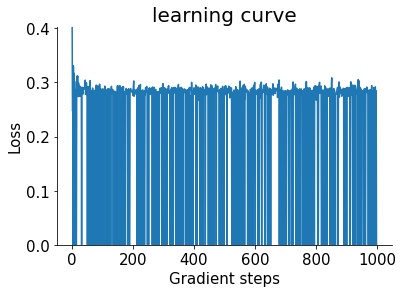

In [4]:
# torch.manual_seed(42)

# Initialize RNN
input_size = 2
output_size = 2
fbi_size = 6

model = FBI_RNN(input_size, output_size, fbi_size)

# Train network
num_epochs = 1000
num_timesteps = 9
eval_step = 8
num_BPTT_steps = 5 #how many steps in the past to backpropagate the error
lr = 0.02
all_patterns = torch.tensor([[0., 1.],[1., 0.],[1., 1.],[0., 0.]])

output_history, fbi_history, loss_history, weight_history = model.train(num_epochs, num_timesteps, num_BPTT_steps, all_patterns, lr)

plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)
sns.despine()
plt.show()

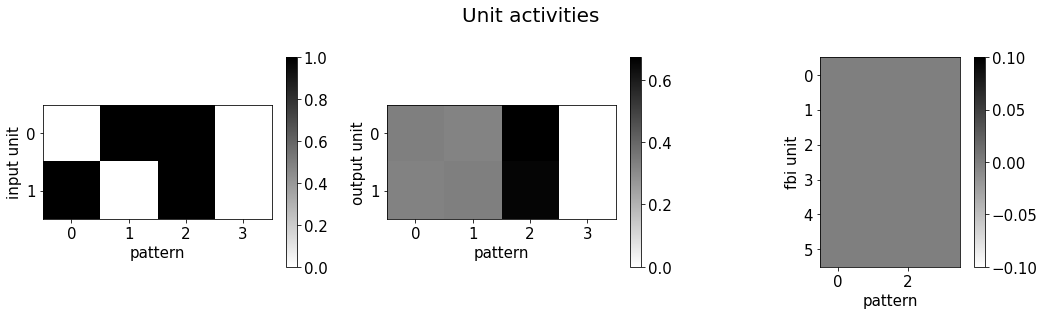

In [5]:
epoch = -1
time = eval_step

def plot_activity(time,epoch=-1):
    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal',cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmin=0,cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmin=0,cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_activity(time,epoch)
# print(f'bias = {model.in2out.bias.detach()}')

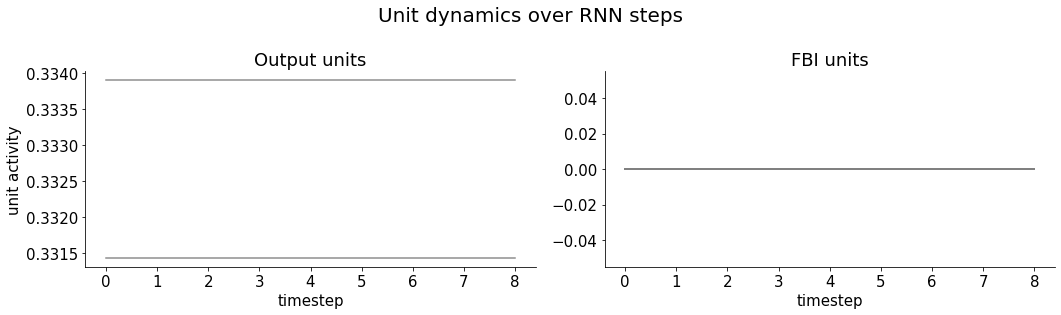

In [6]:
fix, ax = plt.subplots(1,2,figsize=(15,4.5))
for i in range(output_size):
    ax[0].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.9)
ax[0].set_xlabel('timestep')
ax[0].set_ylabel('unit activity')
ax[0].set_title('Output units')

for i in range(fbi_size):
    ax[1].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.9)
ax[1].set_xlabel('timestep')
ax[1].set_title('FBI units')  
    
plt.suptitle('Unit dynamics over RNN steps',fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

In [7]:
import ipywidgets as widgets

widgets.interact(plot_activity, time=(0,num_timesteps-1,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=4, description='time', max=8), IntSlider(value=-1, description='epoch', …

In [8]:
def plot_activity2(epoch):
    epoch = epoch*10
    time = -1

    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal',cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmin=0,cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmin=0,cmap='gray_r')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity2, epoch=(0,99,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=49, description='epoch', max=99), Output()), _dom_classes=('widget-inter…

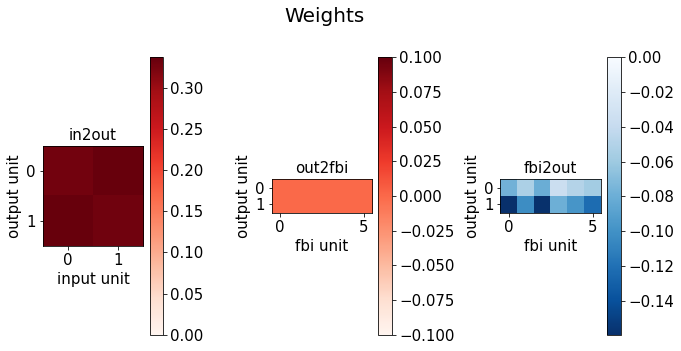

In [9]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

axis = 0
im = ax[axis].imshow(weight_history['in2out'][:,:,epoch],aspect='equal',cmap='Reds',vmin=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('input unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('in2out',fontsize=15)

axis = 1
im = ax[axis].imshow(weight_history['out2fbi'][:,:,epoch].T,aspect='equal',cmap='Reds',vmin=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('output unit')
ax[axis].set_xlabel('fbi unit')
ax[axis].set_title('out2fbi',fontsize=15)

axis = 2
im = ax[axis].imshow(weight_history['fbi2out'][:,:,epoch],aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('fbi unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('fbi2out',fontsize=15)

plt.suptitle("Weights",fontsize=20)
plt.tight_layout()
plt.show()

# print(f'bias = {model.in2out.bias.detach()}')

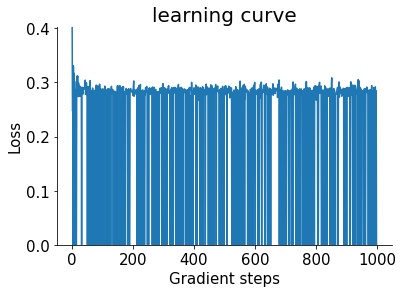

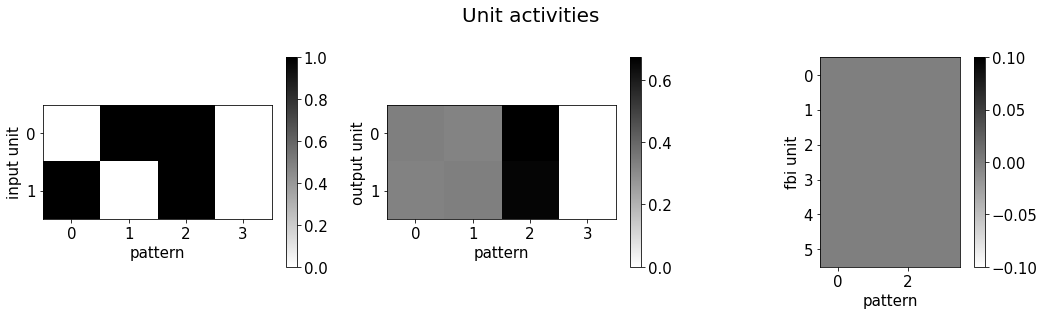

In [10]:
plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)
sns.despine()

plot_activity(time=eval_step,epoch=-1)
# print(f'bias = {model.in2out.bias.detach()}')